In [1]:
%matplotlib inline
import grale.lenses as lenses
import grale.cosmology as cosmology
import grale.plotutil as plotutil
import grale.feedback as feedback
import grale.images as images
from grale.constants import *
import numpy as np
import matplotlib.pyplot as plt

V = lambda x,y: np.array([x,y], dtype=np.double)

feedback.setDefaultFeedback("notebook")

In [2]:
# This is a helper routine to create a 3D plot of the density of a lens, as well as
# critical lines and caustics for Dds/Ds = 0.8
def createPlots(lens, bottomleft, topright):
    lensInfo = { 
        "lens": lens, 
        "bottomleft": bottomleft,
        "topright": topright,
        "Ds": 1,
        "Dds": 0.8
    }
    plt.figure(figsize=(24,12))
    plt.subplot(1,2,1)
    plotutil.plotDensityGnuplot(None, lensInfo, angularUnit=ANGLE_ARCSEC)
    plt.subplot(1,2,2)
    plotutil.plotImagePlane(lensInfo, angularUnit=ANGLE_ARCSEC)
    return lensInfo

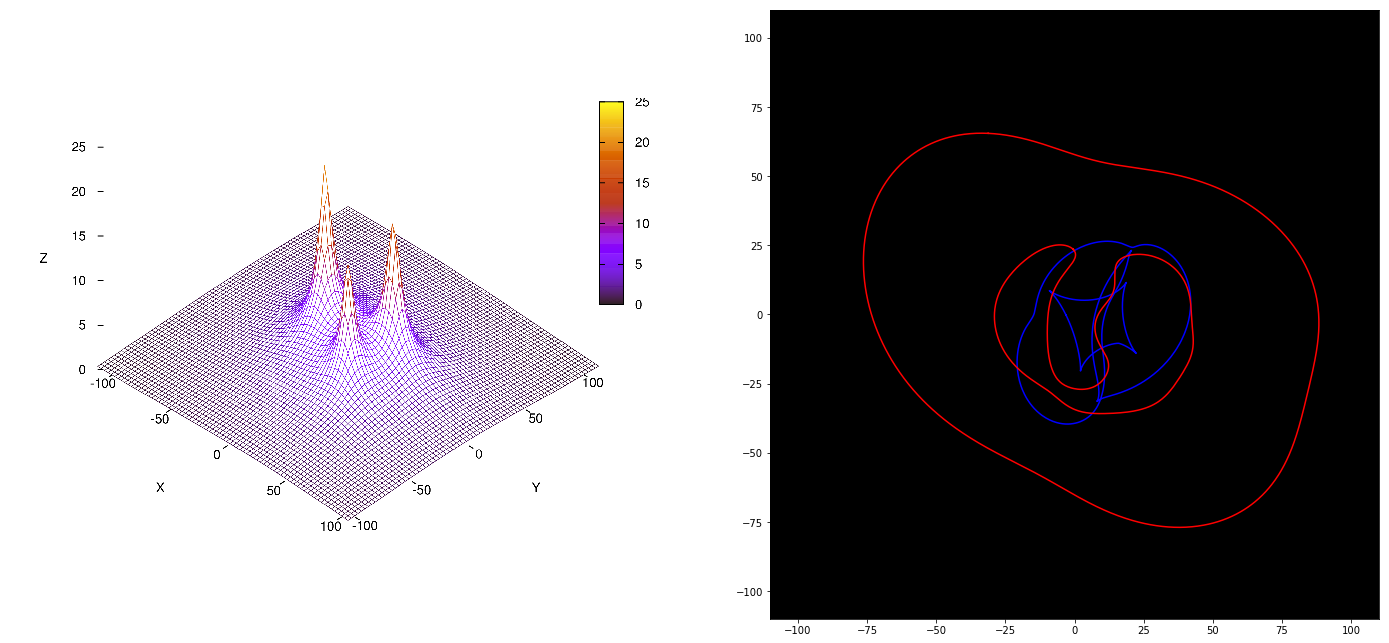

In [3]:
# First we're going to load an actual lens model and visualize it in some plots. In
# a next step, we'll obtain the deflection angles of this lens at evenly spaced points
# which we'll use to create a DeflectionGridLens instance
realLens = lenses.GravitationalLens.load("reallens_nosheet.lensdata")
bl = V(-110,-110)*ANGLE_ARCSEC
tr = V(110,110)*ANGLE_ARCSEC

lensInfoReal = createPlots(realLens, bl, tr)

In [4]:
# Here we'll store the deflection angles of this real lens model in a
# 512x512 grid. 
deflectionAngles = np.zeros((512,512,2))

# The bottom left corner will correspond with the deflection angle
# at the 0,0 position; the top right corner corresponds with the
# other extreme. The 'div' variable below will contain the spacing
# in each direction; to calculate it we must to a -1 for the grid
# shapes to make sure that point 511,511 will correspond exactly to
# the topright point
div = V(deflectionAngles.shape[1]-1, deflectionAngles.shape[0]-1)
for y in range(deflectionAngles.shape[0]):
    for x in range(deflectionAngles.shape[1]):
        # Calculate the image plane position (theta) that corresponds
        # to the grid position, based on the bottom left and top tight
        # coordinates
        theta = (tr-bl)/div * V(x,y) + bl
        
        # Get the real deflection angle at that point, and store it in
        # our grid
        deflectionAngles[y,x,:] = realLens.getAlphaVector(theta)

In [5]:
# With this grid, we can now create a DeflectionGridLens. When the deflection
# angle is queried precisely at one of the stored points, then that will be
# retrieved. For other positions, each component of the deflection angle will
# be bi-linearly interpolated

Dd = realLens.getLensDistance()
dgLens = lenses.DeflectionGridLens(Dd, {
    'angles': deflectionAngles,
    'bottomleft': bl,
    'topright': tr
})

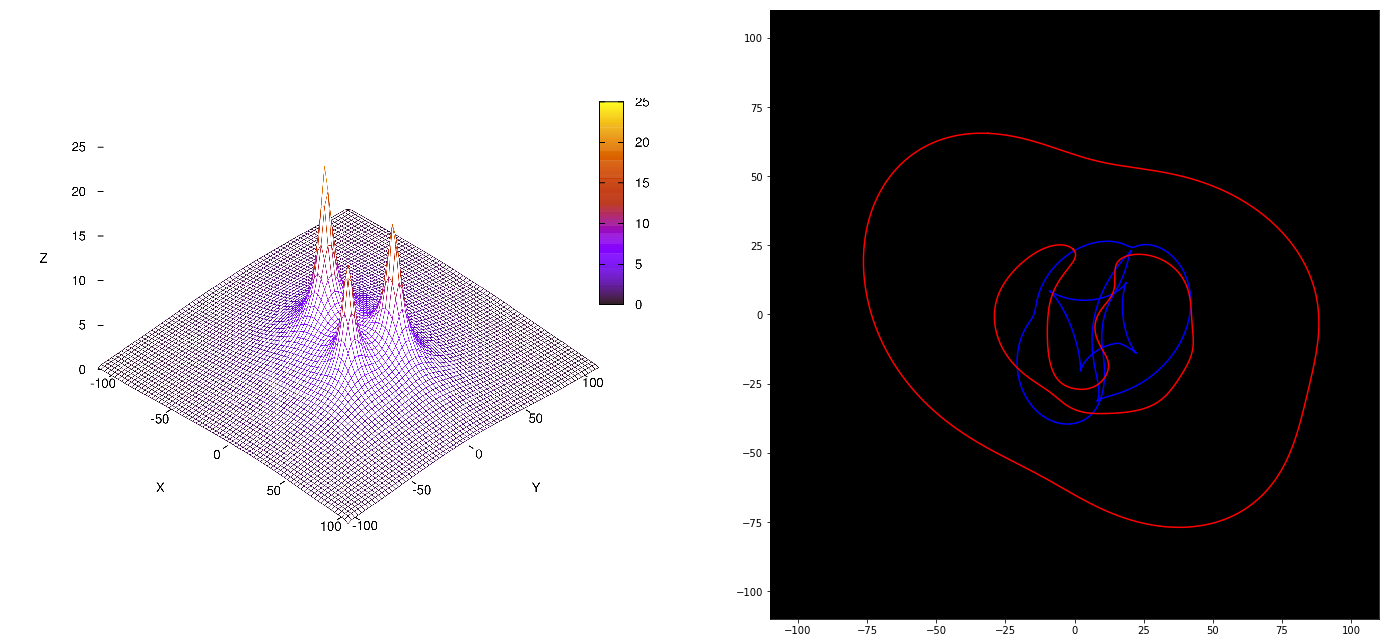

In [6]:
# Let's create some plots for this lens as well. They should look nearly identical
# to the plots above
lensInfoDG = createPlots(dgLens, bl, tr)

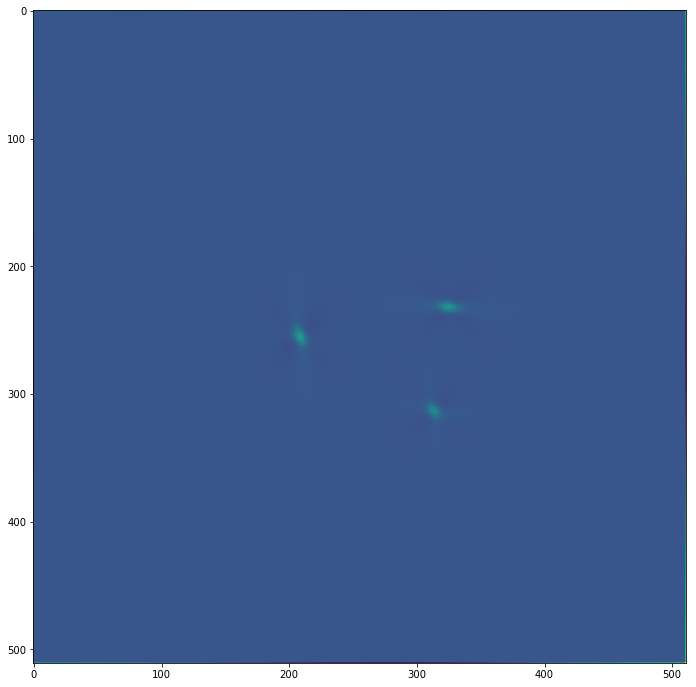

In [7]:
# To show that they're not really identical, let's plot the difference between
# the densities that were calculated
densDiff = lensInfoReal["densitypixels"] - lensInfoDG["densitypixels"]
plt.figure(figsize=(12,12))
plt.imshow(densDiff)

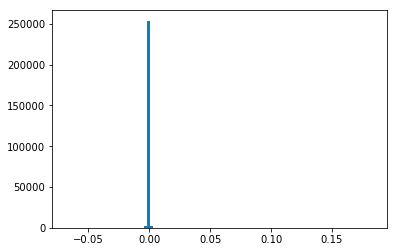

In [8]:
# And if we show a histogram of the differences, it's clear that the difference will
# be very low, but not exactly zero
plt.hist(densDiff.reshape(densDiff.shape[0]*densDiff.shape[1]), bins=100);